<a href="https://colab.research.google.com/github/yklise/YUNI/blob/main/nilaik.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [134]:
import time
import folium
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.graph_objs as go
from datetime import datetime
from tqdm import tqdm_notebook

import geopy
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

import plotly.express as px
from matplotlib import pyplot as plt


import sklearn
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn_pandas import DataFrameMapper
from sklearn.metrics.pairwise import euclidean_distances

In [135]:
df = pd.read_csv("/content/DATABARUFIX.csv")
df.drop(["NO", "TGL"], axis="columns", inplace=True)
df.columns = ["day", "time", "address", "district", "accident_types", "suspect_vehicle", "victim_vehicle"]
print(df.shape)
df.head()

(3706, 7)


,day,time,address,district,accident_types,suspect_vehicle,victim_vehicle
0,Thursday,21:56,Abd KADIR,Tamalate,TK,R2,R2
1,Friday,16:30,PERINTIS KEMERDEKAAN,Biringkanaya,TK,R2,R4
2,Friday,7:30,Hertasning,Panakukang,TM,R4,PJ
3,Friday,14:30,PERINTIS KEMERDEKAAN,Biringkanaya,OC,R2,R2
4,Wednesday,22:30,IR. SUTAMI,Tamalanrea,TK,R2,R4


In [136]:
days = df["day"].unique()
print("Total days: {} \n{}\n".format(len(days), days))

Total days: 7 
['Thursday' 'Friday' 'Wednesday' 'Saturday' 'Sunday' 'Monday' 'Tuesday']



In [137]:
accident_type = df["accident_types"].unique()
print("Total accident types: {} \n{}\n".format(len(accident_type), accident_type))

suspect_vehicle = df["suspect_vehicle"].unique()
print("Total vehicle types (suspect): {} \n{}\n".format(len(suspect_vehicle), suspect_vehicle))

victim_vehicle = df["victim_vehicle"].unique()
print("Total vehicle types (victim): {} \n{}\n".format(len(victim_vehicle), victim_vehicle))

Total accident types: 7 
['TK' 'TM' 'OC' 'TL' 'TB' 'T' 'LL']

Total vehicle types (suspect): 9 
['R2' 'R4' 'R6' 'R3' 'R10' 'R14' 'R12' 'R2 ' 'R8']

Total vehicle types (victim): 11 
['R2' 'R4' 'PJ' 'SP' 'R3' 'R6' 'R10' 'LL' 'T' 'R10 ' 'R16']



In [138]:
df["address"] = df["address"].map(lambda x: str(x).strip().lower())
df["district"] = df["district"].map(lambda x: str(x).strip().lower())
df.head()

,day,time,address,district,accident_types,suspect_vehicle,victim_vehicle
0,Thursday,21:56,abd kadir,tamalate,TK,R2,R2
1,Friday,16:30,perintis kemerdekaan,biringkanaya,TK,R2,R4
2,Friday,7:30,hertasning,panakukang,TM,R4,PJ
3,Friday,14:30,perintis kemerdekaan,biringkanaya,OC,R2,R2
4,Wednesday,22:30,ir. sutami,tamalanrea,TK,R2,R4


In [139]:
df = df.replace('NaN', np.nan)
df = df.dropna()
print(df.shape)

(3706, 7)


In [140]:

df["address"] = df["address"].map(lambda x: str(x).strip().lower())
df["district"] = df["district"].map(lambda x: str(x).strip().lower())
df.head()

,day,time,address,district,accident_types,suspect_vehicle,victim_vehicle
0,Thursday,21:56,abd kadir,tamalate,TK,R2,R2
1,Friday,16:30,perintis kemerdekaan,biringkanaya,TK,R2,R4
2,Friday,7:30,hertasning,panakukang,TM,R4,PJ
3,Friday,14:30,perintis kemerdekaan,biringkanaya,OC,R2,R2
4,Wednesday,22:30,ir. sutami,tamalanrea,TK,R2,R4


In [141]:
df["time"] = pd.to_datetime(df['time'], format='%H:%M', errors='coerce')
df["time"] = pd.to_datetime(df["time"]).dt.hour

In [57]:
def conv_time(hour):
    if 5<=hour<=11:
        return "Morning"
    elif 12<=hour<=17:
        return "Afternoon"
    elif 18<=hour<=22:
        return "Evening"
    else:
        return "Night"

df["time"] = df["time"].map(lambda x: conv_time(x))
df.head()

,day,time,address,district,accident_types,suspect_vehicle,victim_vehicle
0,Thursday,Evening,abd kadir,tamalate,TK,R2,R2
1,Friday,Afternoon,perintis kemerdekaan,biringkanaya,TK,R2,R4
2,Friday,Morning,hertasning,panakukang,TM,R4,PJ
3,Friday,Afternoon,perintis kemerdekaan,biringkanaya,OC,R2,R2
4,Wednesday,Evening,ir. sutami,tamalanrea,TK,R2,R4


In [142]:
location_df = df[["address", "district"]].copy()
location_df = location_df.drop_duplicates(subset=['address', 'district'])
location_df.reset_index(drop=True, inplace=True)
print(location_df.shape)
location_df.head()

(695, 2)


,address,district
0,abd kadir,tamalate
1,perintis kemerdekaan,biringkanaya
2,hertasning,panakukang
3,ir. sutami,tamalanrea
4,perintis kemerdekaan,tamalanrea


In [143]:
# we'll add lat and long column into location_df dataframe
location_df['lat'] = ''
location_df['long'] = ''

start_time = datetime.now().strftime("%H:%M:%S")

locator = Nominatim(user_agent="my_app4")
count = 0
for i in tqdm_notebook(range(len(location_df))):
    try:
        address = "jalan "+ (location_df["address"][i]+', '+ location_df["district"][i]).strip()
        location = locator.geocode(address, timeout=8)

        if location != None:
            location_df['lat'][i] = location.latitude
            location_df['long'][i] = location.longitude

        else:
            print(f"[{count}]. {address}")
            location_df['lat'][i] = np.nan
            location_df['long'][i] = np.nan
        count += 1
    except GeocoderTimedOut as e:
        print("Error: geocode failed on input %s with message %s"%(address, e.message))

print("start:", start_time)
print("finish: ", datetime.now().strftime("%H:%M:%S"))
location_df.head()

<ipython-input-143-32f74d8eb22b>:9: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/695 [00:00<?, ?it/s]

[0]. jalan abd kadir, tamalate
[2]. jalan hertasning, panakukang
[3]. jalan ir. sutami, tamalanrea
[5]. jalan citra daya 2, biringkanaya
[6]. jalan andi jemma, rappocini
[7]. jalan bontolempangan, ujung pandang
[10]. jalan jendral sudirman, ujung pandang
[11]. jalan poros bandara, biringkanaya
[12]. jalan manginsidi, rappocini
[13]. jalan bakong, biringkanaya
[15]. jalan toddopuli raya, panakukang
[22]. jalan urip sumoharjo, panakukang
[31]. jalan haji bau mks, ujung pandang
[32]. jalan masjid raya, bontoala
[33]. jalan andi pangerang pettarani, panakukang
[39]. jalan danau tanjung bunga, tamalate
[42]. jalan muh yamin, makassar
[43]. jalan u. pandang, ujung pandang
[45]. jalan boulevard, biringkanaya
[47]. jalan syekh yusuf, rappocini
[51]. jalan balaikota, ujung pandang
[52]. jalan barombong, tamalate
[53]. jalan korban 40000 jiwa, tallo
[54]. jalan abdullah dg sirua, manggala
[56]. jalan andi tonro, manggala
[57]. jalan krg. patingaloang, biringkanaya
[59]. jalan andi pangerang pett

,address,district,lat,long
0,abd kadir,tamalate,NaN,NaN
1,perintis kemerdekaan,biringkanaya,-5.102758,119.51133
2,hertasning,panakukang,NaN,NaN
3,ir. sutami,tamalanrea,NaN,NaN
4,perintis kemerdekaan,tamalanrea,-5.141788,119.480071


In [144]:
location_merged = df.merge(location_df, how='left', left_on=['address', 'district'], right_on=['address', 'district'])
location_merged = location_merged.dropna()
print(location_merged.shape)
location_merged.head()

(2835, 9)


,day,time,address,district,accident_types,suspect_vehicle,victim_vehicle,lat,long
1,Friday,16.0,perintis kemerdekaan,biringkanaya,TK,R2,R4,-5.102758,119.51133
3,Friday,14.0,perintis kemerdekaan,biringkanaya,OC,R2,R2,-5.102758,119.51133
5,Friday,19.0,perintis kemerdekaan,tamalanrea,TK,R4,R4,-5.141788,119.480071
9,Sunday,13.0,katimbang,biringkanaya,TK,R2,R2,-5.138161,119.520878
10,Sunday,11.0,tamangapa raya,manggala,TL,R4,R2,-5.176737,119.484384


In [145]:
location_merged.to_csv("data_with_coordinates_KMeans.csv", index=False)

In [146]:
location_df = pd.read_csv("data_with_coordinates_KMeans.csv")
print(location_df.shape)
location_df.head()


(2835, 9)


,day,time,address,district,accident_types,suspect_vehicle,victim_vehicle,lat,long
0,Friday,16.0,perintis kemerdekaan,biringkanaya,TK,R2,R4,-5.102758,119.511330
1,Friday,14.0,perintis kemerdekaan,biringkanaya,OC,R2,R2,-5.102758,119.511330
2,Friday,19.0,perintis kemerdekaan,tamalanrea,TK,R4,R4,-5.141788,119.480071
3,Sunday,13.0,katimbang,biringkanaya,TK,R2,R2,-5.138161,119.520878
4,Sunday,11.0,tamangapa raya,manggala,TL,R4,R2,-5.176737,119.484384


In [147]:
features_df = location_df[["day", "time", "accident_types", "suspect_vehicle", "victim_vehicle"]].copy()
features_df.head()

,day,time,accident_types,suspect_vehicle,victim_vehicle
0,Friday,16.0,TK,R2,R4
1,Friday,14.0,OC,R2,R2
2,Friday,19.0,TK,R4,R4
3,Sunday,13.0,TK,R2,R2
4,Sunday,11.0,TL,R4,R2


In [148]:
label_features = features_df.copy()

d_label = LabelBinarizer()
day_label = d_label.fit_transform(label_features["day"])
day_mapping = [label for index, label in enumerate(d_label.classes_)]

t_label = LabelBinarizer()
time_label = t_label.fit_transform(label_features["time"])
time_mapping = [label for index, label in enumerate(t_label.classes_)]

type_label = LabelBinarizer()
accident_label = type_label.fit_transform(label_features["accident_types"])
accident_mapping = [label for index, label in enumerate(type_label.classes_)]


suspect_label = LabelBinarizer()
suspect_vehicle_label = suspect_label.fit_transform(label_features["suspect_vehicle"])
suspect_mapping = [label for index, label in enumerate(suspect_label.classes_)]

victim_label = LabelBinarizer()
victim_vehicle_label = victim_label.fit_transform(label_features["victim_vehicle"])
victim_mapping = [label for index, label in enumerate(victim_label.classes_)]




label = day_mapping + time_mapping +accident_mapping +suspect_mapping+victim_mapping
unique_label = list(dict.fromkeys(label))
# unique_label.remove("NOV")

In [149]:
mapper = DataFrameMapper([
     ('day', LabelBinarizer()),
    ('time', LabelBinarizer()),
     ('accident_types', LabelBinarizer()),
    ('suspect_vehicle', LabelBinarizer()),
    ('victim_vehicle', LabelBinarizer()),
    ])

mapper_scaled = mapper.fit_transform(features_df)
df_encoded = pd.DataFrame(mapper_scaled, columns=[label])
df_encoded.drop(["NOV"], axis="columns", inplace=True)
df_encoded = df_encoded.groupby(level=0,axis=1).sum()
df_encoded = df_encoded[unique_label]
df_encoded.head()

,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,LL,OC,T,TB,TK,TL,TM,R10,R12,R14,R2,R2,R3,R4,R6,R8,PJ,R10,SP
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0


In [150]:
df_encoded = pd.DataFrame(mapper_scaled, columns=[label])
df_encoded.drop(["NOV"], axis="columns", inplace=True)
df_encoded = df_encoded.groupby(level=0,axis=1).sum()
df_encoded = df_encoded[unique_label]

print(df_encoded.columns)
print(df_encoded.shape)
pd.set_option('display.max_columns', None)
df_encoded.head(10)

Index([   'Friday',    'Monday',  'Saturday',    'Sunday',  'Thursday',
         'Tuesday', 'Wednesday',         0.0,         1.0,         2.0,
               3.0,         4.0,         5.0,         6.0,         7.0,
               8.0,         9.0,        10.0,        11.0,        12.0,
              13.0,        14.0,        15.0,        16.0,        17.0,
              18.0,        19.0,        20.0,        21.0,        22.0,
              23.0,        'LL',        'OC',         'T',        'TB',
              'TK',        'TL',        'TM',       'R10',       'R12',
             'R14',        'R2',       'R2 ',        'R3',        'R4',
              'R6',        'R8',        'PJ',      'R10 ',        'SP'],
      dtype='object')
(2835, 50)


,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,LL,OC,T,TB,TK,TL,TM,R10,R12,R14,R2,R2,R3,R4,R6,R8,PJ,R10,SP
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0
5,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0
6,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0
7,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2,0,0,0,0,0,0,0,0
8,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0
9,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0


In [151]:
df_encoded[unique_label] = df_encoded[unique_label].where(~(df_encoded[unique_label]>1),other=1)
print(df_encoded.shape)
df_encoded.head(10)

(2835, 50)


,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,LL,OC,T,TB,TK,TL,TM,R10,R12,R14,R2,R2,R3,R4,R6,R8,PJ,R10,SP
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0
5,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0
6,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
7,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
8,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
9,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0


In [165]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

def compute_gap_statistic(X, K):
    gap_statistics = []
    for k in K:
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X)
        labels = kmeans.labels_
        inertia = kmeans.inertia_

        # Generate random data with similar distribution to original data
        random_data = np.random.rand(*X.shape)

        # Calculate inertia or SSE for each k value from k-means on each random dataset
        kmeans_random = KMeans(n_clusters=k)
        kmeans_random.fit(random_data)
        inertia_random = kmeans_random.inertia_

        # Calculate Gap Statistics for each k
        gap = np.log(inertia_random) - np.log(inertia)
        gap_statistics.append(gap)

    return gap_statistics

# Load data from CSV file
data = df_encoded  # Change 'data.csv' to your CSV file name

# Convert data to numpy array
X = data.values

# Range of k values to be tested
K = range(2, 15)

# Calculate Gap Statistics
gap_statistics = compute_gap_statistic(X, K)

# Select the k value that gives the largest Gap Statistics
best_k_gap = np.argmax(gap_statistics) + 2  # Indices start from 0, and K values start from 2

print("Best K (Gap Statistics):", best_k_gap)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

Best K (Gap Statistics): 14


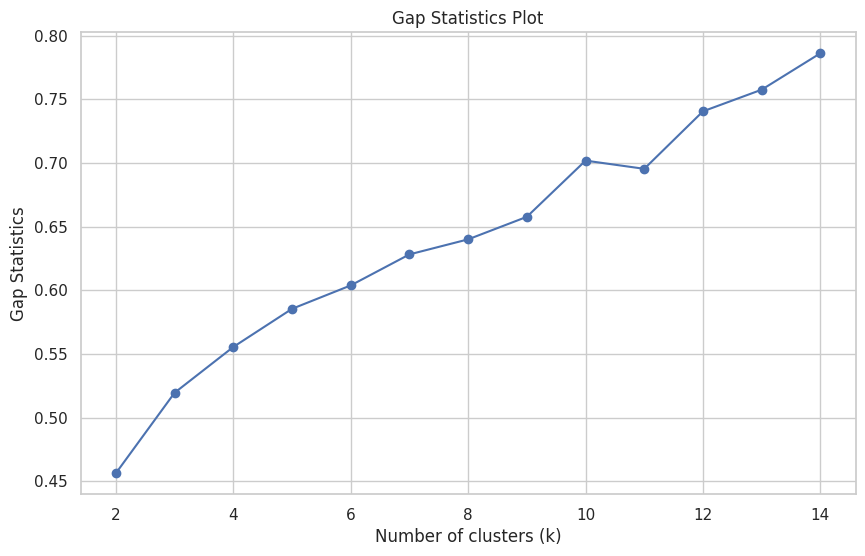

In [167]:
# Plot Gap Statistics against k
plt.figure(figsize=(10, 6))
plt.plot(K, gap_statistics, marker='o', linestyle='-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Gap Statistics')
plt.title('Gap Statistics Plot')
plt.grid(True)
plt.show()

[0.12474564 0.07958259 0.05465716 0.05352999 0.04987033 0.04872625
 0.04781302 0.04654983 0.04585951 0.04366223 0.03670269 0.03291397]


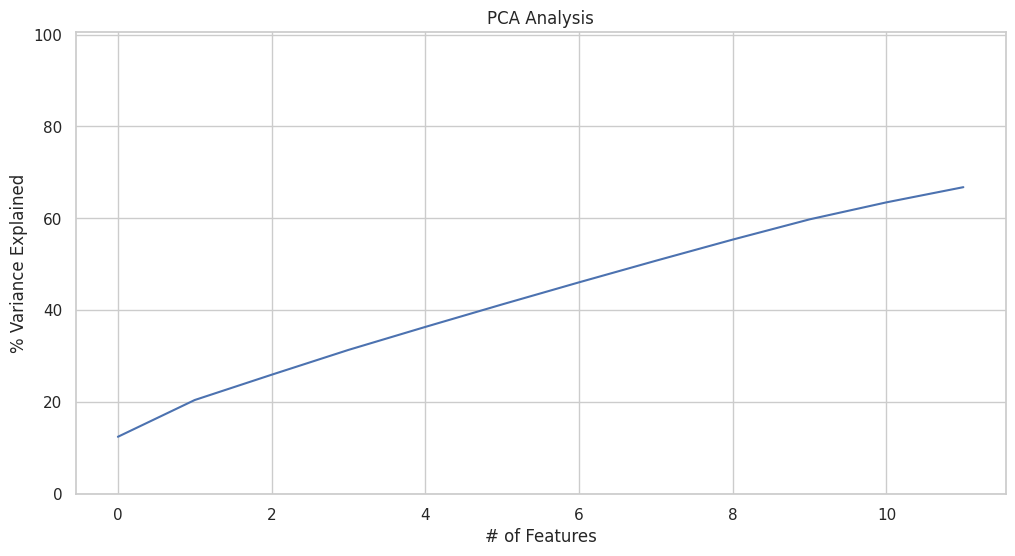

In [168]:
# EXPLAINED VARIANCE FOR 12 FEATURES
pca = PCA(n_components=12)
pca.fit(df_encoded)
variance = pca.explained_variance_ratio_
print(variance)
var=np.cumsum(np.round(variance, 3)*100)
plt.figure(figsize=(12,6))
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.ylim(0,100.5)
plt.plot(var)

In [169]:
pca = PCA(n_components=3).fit(df_encoded)
pca2 = pca.transform(df_encoded)

pca_df = pd.DataFrame(pca2)
print(pca_df.shape)
pca_df.head()

(2835, 3)


,0,1,2
0,-0.683315,0.651893,0.884448
1,0.215253,-0.550111,0.895201
2,-0.676750,0.850523,0.864443
3,-0.599146,-0.223605,-0.259153
4,0.748328,0.800708,-0.165992


In [171]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

def compute_gap_statistic(X, K):
    gap_statistics = []
    for k in K:
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X)
        labels = kmeans.labels_
        inertia = kmeans.inertia_

        # Generate random data with similar distribution to original data
        random_data = np.random.rand(*X.shape)

        # Calculate inertia or SSE for each k value from k-means on each random dataset
        kmeans_random = KMeans(n_clusters=k)
        kmeans_random.fit(random_data)
        inertia_random = kmeans_random.inertia_

        # Calculate Gap Statistics for each k
        gap = np.log(inertia_random) - np.log(inertia)
        gap_statistics.append(gap)

    return gap_statistics

# Load data from CSV file
data = pca_df # Change 'data.csv' to your CSV file name

# Convert data to numpy array
X = data.values

# Range of k values to be tested
K = range(2, 15)

# Calculate Gap Statistics
gap_statistics = compute_gap_statistic(X, K)

# Select the k value that gives the largest Gap Statistics
best_k_gap = np.argmax(gap_statistics) + 2  # Indices start from 0, and K values start from 2

print("Best K (Gap Statistics):", best_k_gap)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

Best K (Gap Statistics): 14


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



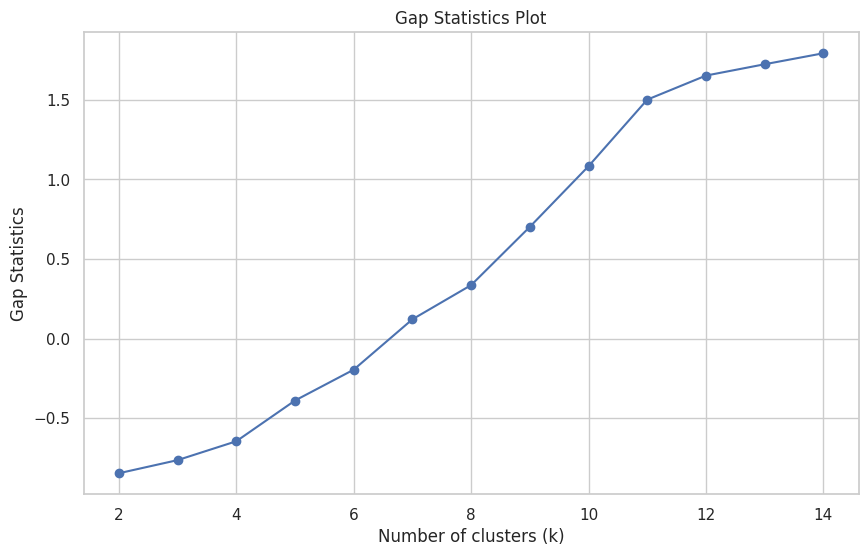

In [172]:
# Plot Gap Statistics against k
plt.figure(figsize=(10, 6))
plt.plot(K, gap_statistics, marker='o', linestyle='-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Gap Statistics')
plt.title('Gap Statistics Plot')
plt.grid(True)
plt.show()

In [173]:
def PCA_Scratch(X , num_components):

    #Step-1
    X_meaned = X - np.mean(X , axis = 0)

    #Step-2
    cov_mat = np.cov(X_meaned , rowvar = False)

    #Step-3
    eigen_values , eigen_vectors = np.linalg.eigh(cov_mat)

    #Step-4
    sorted_index = np.argsort(eigen_values)[::-1]
    sorted_eigenvalue = eigen_values[sorted_index]
    sorted_eigenvectors = eigen_vectors[:,sorted_index]

    #Step-5
    eigenvector_subset = sorted_eigenvectors[:,0:num_components]

    #Step-6
    X_reduced = np.dot(eigenvector_subset.transpose() , X_meaned.transpose() ).transpose()

    return X_reduced

#Applying it to PCA function
mat_reduced = PCA_Scratch(df_encoded , 3)
# Creating a Pandas DataFrame of reduced Dataset
pca_df = pd.DataFrame(mat_reduced , columns = [0,1,2])

#Concat it with target variable to create a complete Dataset
pca_df = pd.concat([pca_df] , axis = 1)
pca_df.head()

,0,1,2
0,-0.683315,-0.651894,0.884421
1,0.215253,0.550110,0.895234
2,-0.676750,-0.850522,0.864505
3,-0.599147,0.223606,-0.259138
4,0.748328,-0.800708,-0.166003


<ipython-input-174-a4e283c61c3f>:5: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



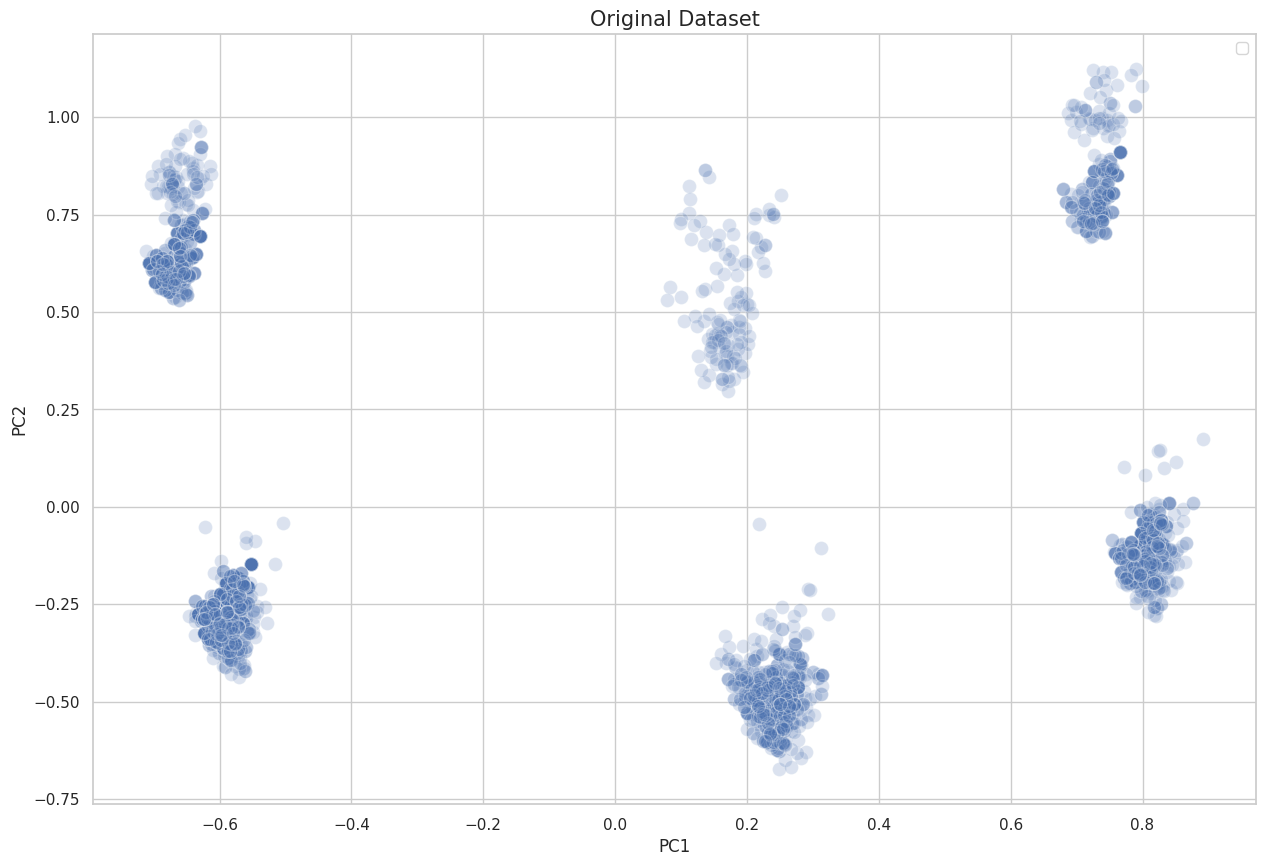

In [174]:
plt.figure(figsize = (15,10))
sns.set(style="whitegrid")

# Membuat scatter plot
ax = sns.scatterplot(x=pca2[:, 0], y=pca2[:, 1], palette='Set1', s=100, alpha=0.2)

# Menambahkan judul plot
ax.set_title('Original Dataset', fontsize=15)

plt.legend()
plt.ylabel('PC2')
plt.xlabel('PC1')
plt.show()

In [175]:

Scene = dict(xaxis = dict(title  = 'PC1'),yaxis = dict(title  = 'PC2'),zaxis = dict(title  = 'PC3'))
trace = go.Scatter3d(x=pca2[:,0], y=pca2[:,1], z=pca2[:,2], mode='markers',marker=dict(color = "black", colorscale='Viridis', size = 10, line = dict(color = 'gray',width = 5)))
layout = go.Layout(margin=dict(l=0,r=0),scene = Scene, height = 800,width = 800)

data = [trace]
fig = go.Figure(data = data, layout = layout)
fig.show()

In [176]:
from scipy import stats
import numpy as np

test_df = pca_df.copy()
z = np.abs(stats.zscore(test_df))
print(z)

threshold = 3
print(np.where(z > 3))

             0         1         2
0     1.129735  1.349386  2.209040
1     0.355880  1.138699  2.236049
2     1.118882  1.760536  2.159297
3     0.990578  0.462852  0.647254
4     1.237222  1.657424  0.414629
...        ...       ...       ...
2830  0.363041  0.915905  0.275862
2831  0.436554  1.058938  0.467009
2832  0.308792  0.957691  2.331926
2833  0.376842  1.245498  0.430404
2834  1.091274  1.333789  0.550068

[2835 rows x 3 columns]
(array([], dtype=int64), array([], dtype=int64))


In [177]:
Q1 = test_df.quantile(0.25)
Q3 = test_df.quantile(0.75)
IQR = Q3 - Q1

print("IQR for 3D data: ")
print(IQR)

IQR for 3D data: 
0    1.328857
1    0.917275
2    0.103629
dtype: float64


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

Best K (Gap Statistics): 14


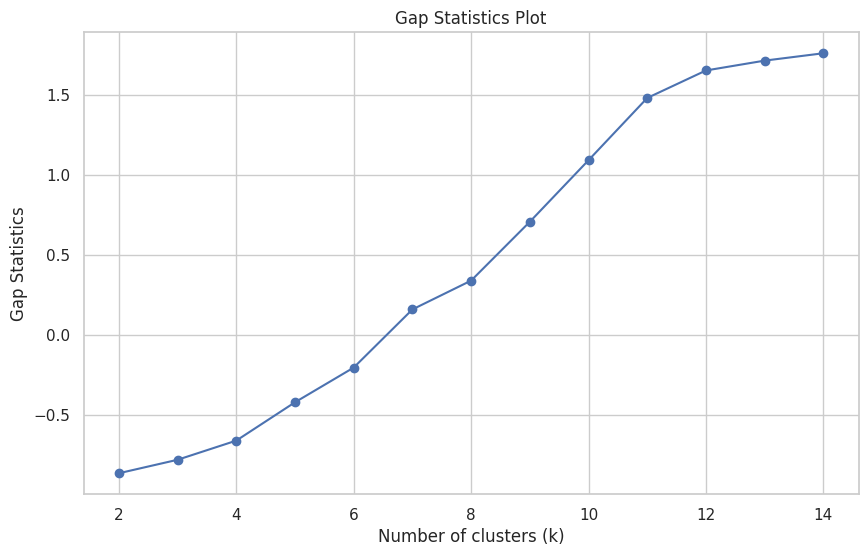

In [178]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def compute_gap_statistic(X, K):
    gap_statistics = []
    for k in K:
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X)
        labels = kmeans.labels_
        inertia = kmeans.inertia_

        # Generate random data with similar distribution to original data
        random_data = np.random.rand(*X.shape)

        # Calculate inertia or SSE for each k value from k-means on each random dataset
        kmeans_random = KMeans(n_clusters=k)
        kmeans_random.fit(random_data)
        inertia_random = kmeans_random.inertia_

        # Calculate Gap Statistics for each k
        gap = np.log(inertia_random) - np.log(inertia)
        gap_statistics.append(gap)

    return gap_statistics

# Load data from CSV file
data = test_df  # Change 'data.csv' to your CSV file name

# Convert data to numpy array
X = data.values

# Range of k values to be tested
K = range(2, 15)

# Calculate Gap Statistics
gap_statistics = compute_gap_statistic(X, K)

# Select the k value that gives the largest Gap Statistics
best_k_gap = np.argmax(gap_statistics) + 2  # Indices start from 0, and K values start from 2

print("Best K (Gap Statistics):", best_k_gap)

# Plot Gap Statistics against k
plt.figure(figsize=(10, 6))
plt.plot(K, gap_statistics, marker='o', linestyle='-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Gap Statistics')
plt.title('Gap Statistics Plot')
plt.grid(True)
plt.show()


In [179]:
def SSE_KMEANS(sse_df, k):

    clusters_point = {}
    sse = {}

    for index, row in sse_df.iterrows():
        label = row["Label"].astype(int)

        if label not in clusters_point:
            temp_df = sse_df.copy()
            temp_df = temp_df.loc[temp_df["Label"] == label]

            column_0_sum = format(temp_df[0].sum()/temp_df.shape[0], ".6f")
            column_1_sum = format(temp_df[1].sum()/temp_df.shape[0], ".6f")
            column_2_sum = format(temp_df[2].sum()/temp_df.shape[0], ".6f")

            core_point = [column_0_sum, column_1_sum, column_2_sum]
            clusters_point[label] = core_point

        x = row[0]
        y = row[1]
        z = row[2]

        corepoint = np.array(clusters_point[label]).astype(float)
        sse_formula = ((x - corepoint[0])**2) + ((y - corepoint[1])**2) + ((z - corepoint[2])**2)

        if label in sse:
            prev_sse = sse[label]
            sse_cluster = prev_sse + sse_formula
            sse[label] = sse_cluster

        else:
            sse[label] = sse_formula

    values = sse.values()

    print(f"SSE K = {k}: ")
    print(f"SSE value for each cluster in {k} clusters: {dict(sorted(sse.items()))}")
    print()

    SSE = sum(values)
    return SSE

In [180]:
## Clustering with KMeans
start_time = datetime.now().strftime("%H:%M:%S")

sse = []
sse_scratch = []
silhouette = []
km_labels = []

K = list(range(2, 15))

for k in K:

    kmeans = KMeans(n_clusters=k).fit(pca_df)

    labels = kmeans.labels_
    km_labels.append(labels)

    score = metrics.silhouette_score(pca_df, labels)
    silhouette.append(score)
    sse.append(kmeans.inertia_)

    sse_df = pca_df.copy()
    sse_df['Label'] = labels

    sse_value = SSE_KMEANS(sse_df, k)
    sse_scratch.append(sse_value)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



SSE K = 2: 
SSE value for each cluster in 2 clusters: {0: 737.9182448940486, 1: 494.2932946228065}



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



SSE K = 3: 
SSE value for each cluster in 3 clusters: {0: 270.99749215458337, 1: 232.976869589249, 2: 430.1560706748749}



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



SSE K = 4: 
SSE value for each cluster in 4 clusters: {0: 103.99181832758595, 1: 143.85731409156443, 2: 307.5494918486213, 3: 81.60576311718431}



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



SSE K = 5: 
SSE value for each cluster in 5 clusters: {0: 5.3281661211520275, 1: 116.6287810981036, 2: 81.60576311718431, 3: 75.60588127412099, 4: 134.16838915599183}



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



SSE K = 6: 
SSE value for each cluster in 6 clusters: {0: 5.3281661211520275, 1: 34.87485396079744, 2: 116.6287810981036, 3: 4.806182111991595, 4: 46.54634173413136, 5: 75.27401766487678}



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



SSE K = 7: 
SSE value for each cluster in 7 clusters: {0: 5.3281661211520275, 1: 46.52601727631599, 2: 3.6074927005724224, 3: 4.806182111991595, 4: 46.54634173413136, 5: 63.462240620978164, 6: 4.745281028931095}



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



SSE K = 8: 
SSE value for each cluster in 8 clusters: {0: 46.54634173413136, 1: 4.745281028931095, 2: 5.3281661211520275, 3: 34.87485396079744, 4: 4.806182111991595, 5: 20.020826549991835, 6: 3.6074927005724224, 7: 7.287715838230085}



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



SSE K = 9: 
SSE value for each cluster in 9 clusters: {0: 3.6074927005724224, 1: 5.3281661211520275, 2: 4.806182111991595, 3: 0.16497016252371263, 4: 34.87485396079744, 5: 4.745281028931095, 6: 20.020826549991835, 7: 0.5458956581447623, 8: 7.287715838230085}



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



SSE K = 10: 
SSE value for each cluster in 10 clusters: {0: 2.743631207414012, 1: 5.3281661211520275, 2: 4.745281028931095, 3: 0.16497016252371263, 4: 4.806182111991595, 5: 3.6074927005724224, 6: 20.020826549991835, 7: 3.461679991933187, 8: 0.5458956581447623, 9: 7.287715838230085}



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



SSE K = 11: 
SSE value for each cluster in 11 clusters: {0: 0.16497016252371263, 1: 4.745281028931095, 2: 4.806182111991595, 3: 3.6074927005724224, 4: 5.3281661211520275, 5: 3.461679991933187, 6: 0.5458956581447623, 7: 0.21337472779708483, 8: 7.287715838230085, 9: 2.743631207414012, 10: 0.31438092616848734}



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



SSE K = 12: 
SSE value for each cluster in 12 clusters: {0: 3.6074927005724224, 1: 5.3281661211520275, 2: 3.461679991933187, 3: 4.806182111991595, 4: 0.31438092616848734, 5: 4.745281028931095, 6: 0.16497016252371263, 7: 0.5458956581447623, 8: 0.21337472779708483, 9: 2.743631207414012, 10: 0.3969633963493056, 11: 0.42067646299744815}



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



SSE K = 13: 
SSE value for each cluster in 13 clusters: {0: 0.21337472779708483, 1: 0.8356697102921059, 2: 3.6074927005724224, 3: 4.806182111991595, 4: 2.743631207414012, 5: 4.745281028931095, 6: 0.16497016252371263, 7: 0.5458956581447623, 8: 3.461679991933187, 9: 0.3969633963493056, 10: 0.31438092616848734, 11: 0.42067646299744815, 12: 1.3150391155957992}



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



SSE K = 14: 
SSE value for each cluster in 14 clusters: {0: 4.745281028931095, 1: 0.8356697102921059, 2: 3.461679991933187, 3: 0.6067099042725907, 4: 0.31438092616848734, 5: 3.6074927005724224, 6: 0.16497016252371263, 7: 0.42067646299744815, 8: 0.21337472779708483, 9: 0.5458956581447623, 10: 0.3969633963493056, 11: 2.743631207414012, 12: 1.3150391155957992, 13: 1.1496633227314093}



start:  04:40:06
finish:  04:40:22


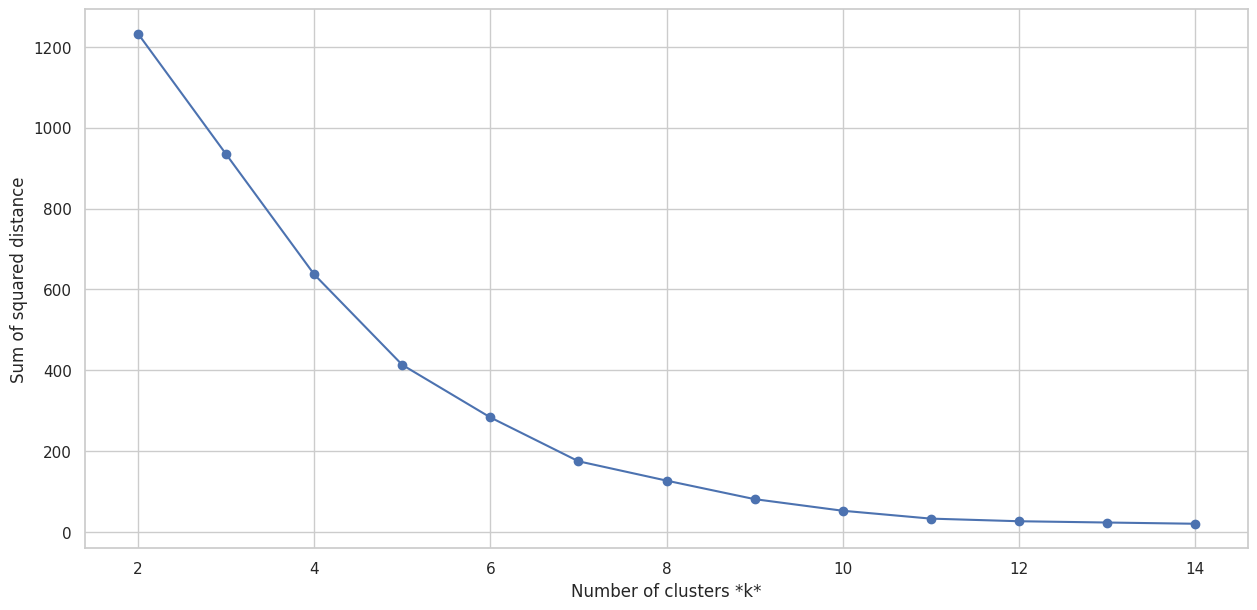

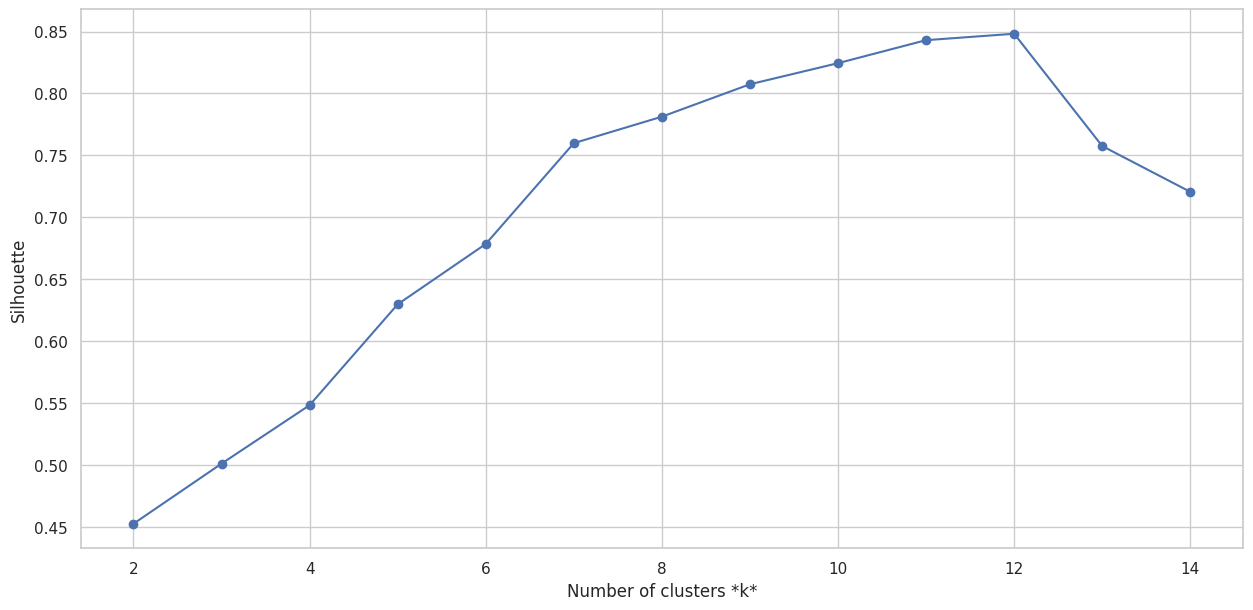

In [181]:
print("start: ", start_time)
print("finish: ", datetime.now().strftime("%H:%M:%S"))

# Plot sse against k
plt.figure(figsize=(15, 7))
plt.plot(K, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

# Plot sse against k
plt.figure(figsize=(15, 7))
plt.plot(K, silhouette, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Silhouette');

In [128]:
kmeans_result = list(zip(K, sse, sse_scratch, silhouette))
kmeans_result = pd.DataFrame(kmeans_result, columns=['clusters','SSE', 'SSE_SCRATCH', 'silhouette_score'])

pd.set_option('display.max_rows', kmeans_result.shape[0]+1)
kmeans_result

,clusters,SSE,SSE_SCRATCH,silhouette_score
0,2,2283.080464,2283.080464,0.354153
1,3,1564.452309,1564.452309,0.449898
2,4,1151.716861,1151.716861,0.464881
3,5,728.584494,728.584494,0.557217
4,6,377.387406,377.387406,0.641319
5,7,320.322506,320.322506,0.616460
6,8,265.887346,265.887346,0.628614
7,9,219.718555,219.716188,0.631862
8,10,179.567514,179.567514,0.638653
9,11,153.054873,153.054873,0.647621


In [129]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import metrics
import numpy as np

# Using KMeans with explicit n_init
kmeans = KMeans(n_clusters=13, n_init='auto', random_state=10).fit(pca_df)  # Set n_init explicitly
labels = kmeans.labels_

# Calculate Silhouette Score
silhouette_score = metrics.silhouette_score(pca_df, labels)
print("Silhouette Score: ", silhouette_score)

# Calculate SSE (Inertia)
sse = kmeans.inertia_
print("SSE: ", sse)

Silhouette Score:  0.6804638039085367
SSE:  117.42731072513803


In [130]:
import numpy as np

class KMeans_scratch:
    def __init__(self, X, num_clusters):
        self.K = num_clusters
        self.max_iterations = 100
        self.num_examples, self.num_features = X.shape

    def initialize_random_centroids(self, X):
        centroids = np.zeros((self.K, self.num_features))
        for k in range(self.K):
            centroid = X[np.random.choice(range(self.num_examples))]
            centroids[k] = centroid
        print("Initial centroids:")
        print(centroids)
        return centroids

    def create_clusters(self, X, centroids):
        clusters = [[] for _ in range(self.K)]
        for point_idx, point in enumerate(X):
            closest_centroid = np.argmin(np.sqrt(np.sum((point - centroids) ** 2, axis=1)))
            clusters[closest_centroid].append(point_idx)
        return clusters

    def calculate_new_centroids(self, clusters, X):
        centroids = np.zeros((self.K, self.num_features))
        for idx, cluster in enumerate(clusters):
            new_centroid = np.mean(X[cluster], axis=0)
            centroids[idx] = new_centroid
        return centroids

    def calculate_sse(self, clusters, centroids, X):
        sse_per_cluster = []
        sse = 0
        for idx, cluster in enumerate(clusters):
            cluster_center = centroids[idx]
            cluster_sse = 0
            for point_idx in cluster:
                point = X[point_idx]
                cluster_sse += np.sum((point - cluster_center) ** 2)
            sse_per_cluster.append(cluster_sse)
            sse += cluster_sse
        return sse, sse_per_cluster

    def fit(self, X):
        # Inisialisasi pusat klaster secara acak
        centroids = self.initialize_random_centroids(X)

        for _ in range(self.max_iterations):
            # Membuat klaster berdasarkan pusat klaster saat ini
            clusters = self.create_clusters(X, centroids)

            # Menghitung pusat klaster baru
            new_centroids = self.calculate_new_centroids(clusters, X)

            # Cek konvergensi
            if np.allclose(new_centroids, centroids):
                break

            centroids = new_centroids

        # Menghitung SSE
        total_sse, sse_per_cluster = self.calculate_sse(clusters, centroids, X)

        # Menyimpan indeks data untuk setiap klaster
        cluster_indices = [[cluster[i] for i in range(len(cluster))] for cluster in clusters]

        return clusters, centroids, total_sse, sse_per_cluster, cluster_indices

# Contoh penggunaan
if __name__ == "__main__":
    # Buat dataset contoh
    np.random.seed(42)
    X = np.random.rand(100, 2)

    # Buat objek kelas KMeans_scratch
    kmeans = KMeans_scratch(X, num_clusters=13)

    # Lakukan k-means clustering dan dapatkan klaster, pusat klaster, total SSE, SSE per klaster, dan indeks data untuk setiap klaster
    clusters, centroids, total_sse, sse_per_cluster, cluster_indices = kmeans.fit(X)

    # Cetak klaster, pusat klaster, total SSE, SSE per klaster, dan indeks data untuk setiap klaster
    print("Final clusters:")
    print(clusters)
    print("Final centroids:")
    print(centroids)
    print("Total SSE:", total_sse)
    print("SSE per cluster:", sse_per_cluster)
    print("Cluster indices:")
    print(cluster_indices)


Initial centroids:
[[0.31171108 0.52006802]
 [0.05147875 0.27864646]
 [0.49724851 0.30087831]
 [0.77224477 0.19871568]
 [0.70685734 0.72900717]
 [0.32078006 0.18651851]
 [0.72595568 0.89711026]
 [0.69093774 0.38673535]
 [0.72595568 0.89711026]
 [0.54671028 0.18485446]
 [0.25794163 0.65998405]
 [0.96563203 0.80839735]
 [0.63352971 0.53577468]]


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:121: RuntimeWarning:

invalid value encountered in divide



Final clusters:
[[], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99], [], [], [], [], [], [], [], [], [], [], []]
Final centroids:
[[       nan        nan]
 [0.48104394 0.48696853]
 [       nan        nan]
 [       nan        nan]
 [       nan        nan]
 [       nan        nan]
 [       nan        nan]
 [       nan        nan]
 [       nan        nan]
 [       nan        nan]
 [       nan        nan]
 [       nan        nan]
 [       nan        nan]]
Total SSE: 17.303475244384728
SSE per cluster: [0, 17.303475244384728, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Cluster indices:
[[], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,

In [131]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Assuming 'labels' is a NumPy array or Pandas Series

# Print unique labels
unique_labels = np.unique(labels)
print(unique_labels)

# Fit PCA
pca2 = PCA(n_components=3).fit(pca_df)
pca2d = pca2.transform(pca_df)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12]


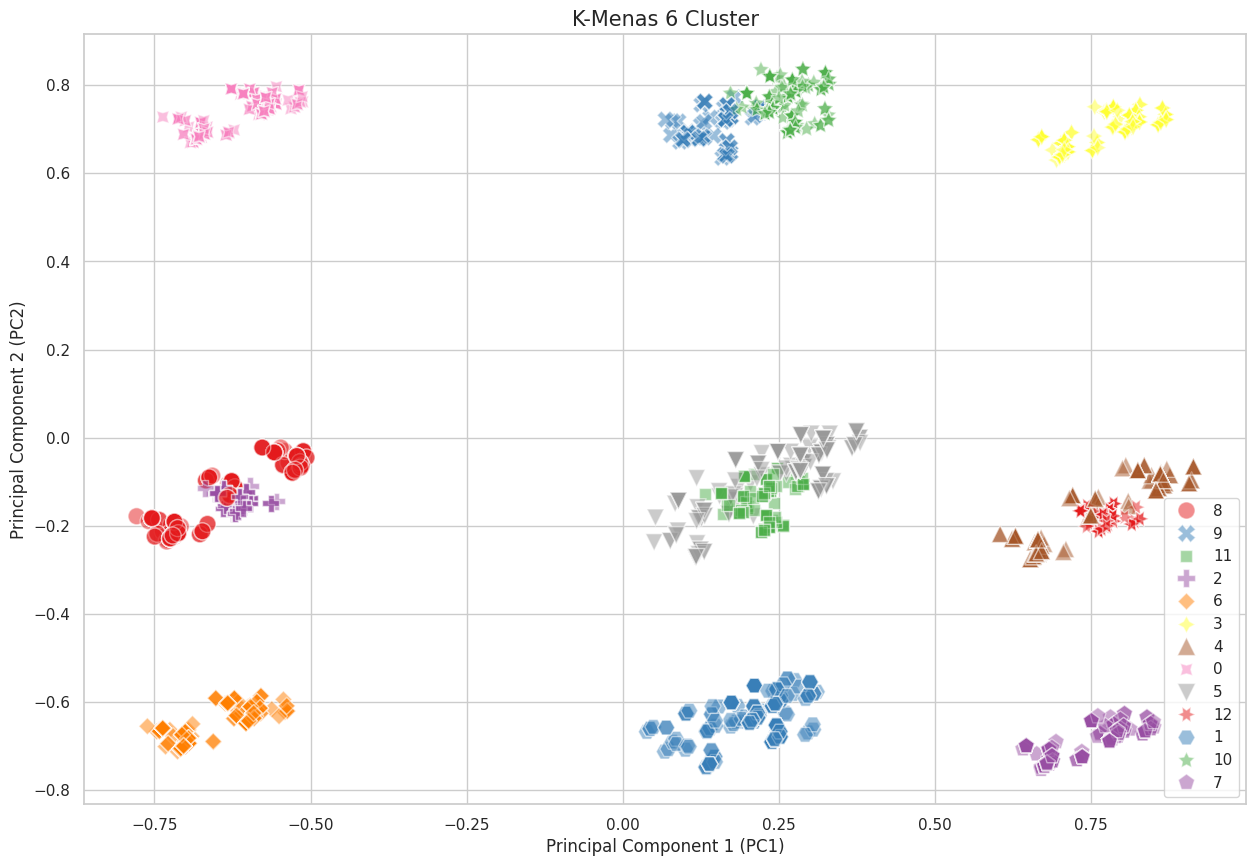

In [132]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Misalnya, kita memiliki dataframe pca_df
# pca_df = ...

# Melakukan PCA
pca2 = PCA(n_components=2).fit(pca_df)
pca2d = pca2.transform(pca_df)

# Membuat scatter plot dengan Seaborn
plt.figure(figsize=(15, 10))
sns.scatterplot(x=pca2d[:, 0], y=pca2d[:, 1], hue=labels.astype(str),
                style=labels.astype(str), palette='Set1', s=150, alpha=0.5)
# sns.scatterplot(x='X', y='Y', hue='Category', palette='Set1', s=150, alpha=0.5, data=df)
plt.title('K-Menas 6 Cluster', fontsize=15)
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.show()

In [ ]:
kmeans_df = location_df.copy()
kmeans_df["Cluster"] =labels
kmeans_df.head(10)

,day,time,address,district,accident_types,suspect_vehicle,victim_vehicle,lat,long,Cluster
0,Friday,Afternoon,perintis kemerdekaan,biringkanaya,TK,R2,R4,-5.087647,119.518822,2
1,Friday,Afternoon,perintis kemerdekaan,biringkanaya,OC,R2,R2,-5.087647,119.518822,3
2,Friday,Evening,perintis kemerdekaan,tamalanrea,TK,R4,R4,-5.141788,119.480071,2
3,Sunday,Afternoon,katimbang,biringkanaya,TK,R2,R2,-5.138161,119.520878,2
4,Sunday,Morning,tamangapa raya,manggala,TL,R4,R2,-5.176737,119.484384,1
5,Sunday,Evening,perintis kemerdekaan,biringkanaya,TL,R4,R2,-5.087647,119.518822,0
6,Monday,Morning,perintis kemerdekaan,biringkanaya,TK,R2,R2,-5.087647,119.518822,4
7,Thursday,Afternoon,gatot subroto,tallo,TL,R2,R2,-5.118241,119.434965,3
8,Friday,Night,perintis kemerdekaan,tamalanrea,TK,R2,R2,-5.141788,119.480071,5
9,Monday,Morning,taman sudiang,biringkanaya,TK,R4,R2,-5.092337,119.530151,4


In [ ]:
kmeans_df.to_csv('hasilclusterbaru.csv', index=False)

In [ ]:
for i in np.unique(labels):
    total = len(kmeans_df.loc[kmeans_df["Cluster"]==i])
    day = np.unique(kmeans_df.loc[kmeans_df["Cluster"]==i]["day"].values)
    time = np.unique(kmeans_df.loc[kmeans_df["Cluster"]==i]["time"].values)
    accident_types = np.unique(kmeans_df.loc[kmeans_df["Cluster"]==i]["accident_types"].values)
    vehicles = np.unique(kmeans_df.loc[kmeans_df["Cluster"]==i]["suspect_vehicle"].values)
    victim = np.unique(kmeans_df.loc[kmeans_df["Cluster"]==i]["victim_vehicle"].values)
    vehicles.remove("NOV") if "NOV" in vehicles else vehicles

    print("""Total data pada Klaster {} adalah {}:
            days: {}
            time: {}
            accident_types: {}
            vehicles involved: {}
            victim involved: {}
        """.format(i, total, day, time, accident_types, vehicles, victim ))

Total data pada Klaster 0 adalah 409:
            days: ['Friday' 'Monday' 'Saturday' 'Sunday' 'Thursday' 'Tuesday' 'Wednesday']
            time: ['Evening' 'Night']
            accident_types: ['LL' 'OC' 'T' 'TB' 'TL' 'TM']
            vehicles involved: ['R10' 'R2' 'R3' 'R4' 'R6']
            victim involved: ['PJ' 'R10' 'R2' 'R3' 'R4' 'R6' 'SP' 'T']
        
Total data pada Klaster 1 adalah 508:
            days: ['Friday' 'Monday' 'Saturday' 'Sunday' 'Thursday' 'Tuesday' 'Wednesday']
            time: ['Morning']
            accident_types: ['LL' 'OC' 'T' 'TB' 'TL' 'TM']
            vehicles involved: ['R10' 'R2' 'R3' 'R4' 'R6']
            victim involved: ['PJ' 'R2' 'R3' 'R4' 'R6' 'SP' 'T']
        
Total data pada Klaster 2 adalah 496:
            days: ['Friday' 'Monday' 'Saturday' 'Sunday' 'Thursday' 'Tuesday' 'Wednesday']
            time: ['Afternoon' 'Evening']
            accident_types: ['TK']
            vehicles involved: ['R10' 'R14' 'R2' 'R2 ' 'R3' 'R4' 'R6' 'R8']
  

In [ ]:
dups_df = kmeans_df.copy()
dups_df['Count'] = 1
dups_df = dups_df.groupby(['address', 'district', 'lat', 'long', 'Cluster']).Count.count().reset_index()
dups_df.shape

(1048, 6)

In [ ]:
dups_df = dups_df.loc[dups_df['Count']>=6]
dups_df.reset_index(drop=True, inplace=True)
dups_df

,address,district,lat,long,Cluster,Count
0,abu bakar lambogo,makassar,-5.142728,119.433644,0,6
1,abu bakar lambogo,makassar,-5.142728,119.433644,3,10
2,andi pangerang pettarani,panakkukang,-5.152195,119.437475,2,7
3,andi pangerang pettarani,panakkukang,-5.152195,119.437475,3,8
4,andi pangerang pettarani,rappocini,-5.156590,119.436907,0,9
...,...,...,...,...,...,...
85,veteran utara,bontoala,-5.140797,119.423995,2,8
86,veteran utara,makassar,-5.139199,119.423302,0,6
87,veteran utara,makassar,-5.139199,119.423302,2,7
88,veteran utara,makassar,-5.139199,119.423302,3,11


In [ ]:
# identified accident-prone location in cluster 0
dups_df.loc[dups_df['Cluster'] == 0]

,address,district,lat,long,Cluster,Count
0,abu bakar lambogo,makassar,-5.144427,119.431430,0,6
4,andi pangerang pettarani,rappocini,-5.156590,119.436907,0,9
15,cendrawasih,mariso,-5.155279,119.412261,0,8
17,galangan kapal,tallo,-5.111690,119.431093,0,7
19,goa ria,biringkanaya,-5.081804,119.524386,0,6
22,hertasning,rappocini,-5.163515,119.438191,0,6
29,metro tanjung bunga,mariso,-5.150355,119.406524,0,10
31,metro tanjung bunga,tamalate,-5.166158,119.391744,0,11
39,penghibur,ujung pandang,-5.143807,119.408143,0,8
40,perintis kemerdekaan,biringkanaya,-5.093458,119.513409,0,32


In [ ]:
# identified accident-prone location in cluster 0
dups_df.loc[dups_df['Cluster'] == 1]

,address,district,lat,long,Cluster,Count
28,maccini raya,makassar,-5.138039,119.434011,1,6
32,metro tanjung bunga,tamalate,-5.166158,119.391744,1,7
41,perintis kemerdekaan,biringkanaya,-5.093458,119.513409,1,18
48,perintis kemerdekaan,tamalanrea,-5.125716,119.504011,1,25
71,urip sumuharjo,panakkukang,-5.134824,119.431682,1,12


In [ ]:
# identified accident-prone location in cluster 0
dups_df.loc[dups_df['Cluster'] == 3]

,address,district,lat,long,Cluster,Count
1,abu bakar lambogo,makassar,-5.144427,119.431430,3,10
3,andi pangerang pettarani,panakkukang,-5.152195,119.437475,3,8
8,aroepala,rappocini,-5.176439,119.457349,3,8
10,borong raya,manggala,-5.163747,119.467370,3,6
20,goa ria,biringkanaya,-5.081804,119.524386,3,8
23,insinyur sutami,biringkanaya,-5.078346,119.507171,3,6
25,insinyur sutami,tamalanrea,-5.103407,119.457241,3,9
26,kumala,tamalate,-5.169866,119.418994,3,7
27,letjen hertasning,rappocini,-5.161581,119.436070,3,6
30,metro tanjung bunga,mariso,-5.150355,119.406524,3,6


In [ ]:
# identified accident-prone location in cluster 0
dups_df.loc[dups_df['Cluster'] == 4]

,address,district,lat,long,Cluster,Count
6,andi pangerang pettarani,rappocini,-5.156590,119.436907,4,9
9,aroepala,rappocini,-5.176439,119.457349,4,6
11,borong raya,manggala,-5.163747,119.467370,4,9
16,cendrawasih,mariso,-5.155279,119.412261,4,7
18,galangan kapal,tallo,-5.111690,119.431093,4,6
35,metro tanjung bunga,tamalate,-5.166158,119.391744,4,8
44,perintis kemerdekaan,biringkanaya,-5.093458,119.513409,4,49
51,perintis kemerdekaan,tamalanrea,-5.125716,119.504011,4,42
63,sultan alauddin,tamalate,-5.174077,119.431242,4,8
74,urip sumuharjo,panakkukang,-5.134824,119.431682,4,10


In [ ]:
# identified accident-prone location in cluster 0
dups_df.loc[dups_df['Cluster'] == 5]

,address,district,lat,long,Cluster,Count
12,borong raya,manggala,-5.163747,119.467370,5,6
14,boulevard,panakukang,-5.156948,119.446554,5,6
36,metro tanjung bunga,tamalate,-5.166158,119.391744,5,6
45,perintis kemerdekaan,biringkanaya,-5.093458,119.513409,5,38
52,perintis kemerdekaan,tamalanrea,-5.125716,119.504011,5,27
55,rajawali,mariso,-5.148750,119.409612,5,8
66,tamalanrea raya,tamalanrea,-5.138984,119.519327,5,7
75,urip sumuharjo,panakkukang,-5.134824,119.431682,5,10
79,veteran selatan,mamajang,-5.167155,119.419923,5,10


In [ ]:
# identified accident-prone location in cluster 0
dups_df.loc[dups_df['Cluster'] == 6]

,address,district,lat,long,Cluster,Count
46,perintis kemerdekaan,biringkanaya,-5.093458,119.513409,6,13
53,perintis kemerdekaan,tamalanrea,-5.125716,119.504011,6,33
59,sultan alauddin,rappocini,-5.184701,119.440854,6,6
76,urip sumuharjo,panakkukang,-5.134824,119.431682,6,13
80,veteran selatan,mamajang,-5.167155,119.419923,6,7


In [ ]:
dups_df.to_csv('hasilcluster.csv', index=False)